# Udacity Deep Reinforcement Learning ND

## Project 3: Collaboration and Competition

### Unity environment: Tennis

This notebook implements a multi-agent DDPG (maddpg) model to solve the Tennis Environment. I solved the environment (average reward greater than 0.5) in less than 8000 training steps.

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
import os
import time
import datetime
import utils
from collections import deque, namedtuple
import pandas as pd
import matplotlib.pyplot as plt

### Network models for Actor and Critic

In [2]:
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=300, fc2_units=300):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, state_size, action_size, nbr_of_agts, seed, fcs1_units=300, fc2_units=300):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size) * nbr_of_agts, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        """Performs forward"""
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer

In [3]:
from collections import deque, namedtuple

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, number_of_agents):

        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        self.number_of_agents = number_of_agents
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        list_of_states = list()
        list_of_actions = list()
        list_of_next_states = list()

        
        for i in range(self.number_of_agents):
            index = np.array([i])
            states = torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device)
            actions = torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device)
            next_states = torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device)
            
            list_of_states.append(states)
            list_of_actions.append(actions)
            list_of_next_states.append(next_states)
            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (list_of_states, list_of_actions, rewards, list_of_next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Action space proportional noise

In [4]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state


### DDPG Agent

In [17]:
import torch.optim as optim
import random
import copy
from collections import namedtuple, deque
import time

class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, agent_id, 
                 state_size, 
                 action_size, 
                 rand_seed, 
                 meta_agent,
                 BUFFER_SIZE = int(1e5),
                 BATCH_SIZE = 250, 
                 GAMMA = 0.99,
                 TAU = 1e-3,
                 LR_ACTOR = 1e-4,
                 LR_CRITIC = 1e-3,
                 UPDATE_EVERY = 2, 
                 WEIGHT_DECAY = 0):
        """
        Initialize an Agent object.
        
        Params
        ======
            state_size (int) : dimension of each state
            action_size (int): dimension of each action
            rand_seed (int): random seed
            BUFFER_SIZE (int): replay buffer size
            BATCH_SIZE (int): minibatch size
            GAMMA (float): discount factor
            TAU (float): for soft update of target parameters
            LR_ACTOR (float): learning rate for critic 
            LR_CRITIC (float): learning rate for critic
            WEIGHT_DECAY (float): L2 weight decay
        """
        self.agent_id = agent_id
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.tau = TAU
        self.update_every = UPDATE_EVERY
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, rand_seed).to(device)
        self.actor_target = Actor(state_size, action_size, rand_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), \
                                            lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, meta_agent.number_of_agents, rand_seed).to(device)
        self.critic_target = Critic(state_size, action_size, meta_agent.number_of_agents, rand_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),\
                                            lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, rand_seed)

        # Time step
        self.timestep = 0
        
        # Replay memory
        self.memory = meta_agent.memory
        
    def step(self):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #for s, a, r, ns, d in zip(state, action, reward, next_state, done):
        #    self.memory.add(s, a, r, ns, d)
            
        self.timestep = (self.timestep + 1) % self.update_every
        
        if self.timestep == 0:
            # if enough samples are available in memory
        
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
                


    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        (states_list, actions_list, rewards, next_states_list, dones) = experiences
        
        list_all_next_actions = []
        for states in states_list:
            list_all_next_actions.append(self.actor_target(states))
        
        # Convert the experiences into Torch tensors
        all_next_actions = torch.cat(list_all_next_actions, dim=1).to(device)
        all_next_states = torch.cat(next_states_list, dim=1).to(device)
        all_states = torch.cat(states_list, dim=1).to(device)
        all_actions = torch.cat(actions_list, dim=1).to(device)
        
        # ---------------------------- update critic ---------------------------- #
        
        # Get predicted next-state actions and Q values from target models
        Q_targets_next = self.critic_target(all_next_states, all_next_actions)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(all_states, all_actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        
        actions_pred = []
        for states in states_list:
            actions_pred.append(self.actor_local(states))
        
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(all_states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
           

### MADDPG agent

In [13]:
class MADDPG:
    '''
    MultiAgent DDPG implementation
    '''

    def __init__(self, 
                 number_of_agents, 
                 state_size, 
                 action_size, 
                 rand_seed,
                 BUFFER_SIZE = int(1e5),
                 BATCH_SIZE  = 250):

        self.number_of_agents = number_of_agents
        self.batch_size = BATCH_SIZE 
        self.buffer_size = BUFFER_SIZE
       
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, rand_seed, self.number_of_agents)
     
        self.action_size = action_size
        self.state_size = state_size 
        print('r seed is: ', rand_seed)
        self.agents = [DDPGAgent(i, self.state_size,
                               self.action_size,
                               rand_seed,
                               self)
                         for i in range(self.number_of_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        """ Add into memory the experience. It will include all agents information """

        self.memory.add(states, actions, rewards, next_states, dones)

        # For each agent perfoms a step 
        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        """ Returns the action to take """
        na_rtn = np.zeros([self.number_of_agents, self.action_size])
        for agent in self.agents:
            idx = agent.agent_id
            na_rtn[idx, :] = agent.act(states[idx], add_noise)
        return na_rtn

    def save_weights(self):
        """ Save agents weights"""
        for agent in self.agents:
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(agent.agent_id+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(agent.agent_id+1))
    
    def reset(self):
        """ Just reset all agents """
        for agent in self.agents:
            agent.reset()

    def __len__(self):
        return self.number_of_agents

    def __getitem__(self, key):
        return self.agents[key]

### Environment and agent

In [9]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('Size of each state:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
Size of each state: 24


### Training

24
action_size:  2
r seed is:  0


C:\Users\nbbor\Anaconda3\envs\tf17\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Avg score: 0.00
Episode 101	Avg score: 0.00
Episode 201	Avg score: 0.00
Episode 301	Avg score: 0.00
Episode 401	Avg score: 0.00
Episode 501	Avg score: 0.00
Episode 601	Avg score: 0.00
Episode 701	Avg score: 0.00
Episode 801	Avg score: 0.01
Episode 901	Avg score: 0.00
Episode 1001	Avg score: 0.00
Episode 1101	Avg score: 0.00
Episode 1201	Avg score: 0.00
Episode 1301	Avg score: 0.00
Episode 1401	Avg score: 0.00
Episode 1501	Avg score: 0.02
Episode 1601	Avg score: 0.01
Episode 1701	Avg score: 0.02
Episode 1801	Avg score: 0.01
Episode 1901	Avg score: 0.01
Episode 2001	Avg score: 0.00
Episode 2101	Avg score: 0.00
Episode 2201	Avg score: 0.02
Episode 2301	Avg score: 0.03
Episode 2401	Avg score: 0.03
Episode 2501	Avg score: 0.05
Episode 2601	Avg score: 0.10
Episode 2701	Avg score: 0.10
Episode 2801	Avg score: 0.11
Episode 2901	Avg score: 0.10
Episode 3001	Avg score: 0.12
Episode 3101	Avg score: 0.15
Episode 3201	Avg score: 0.14
Episode 3301	Avg score: 0.15
Episode 3401	Avg score: 0.

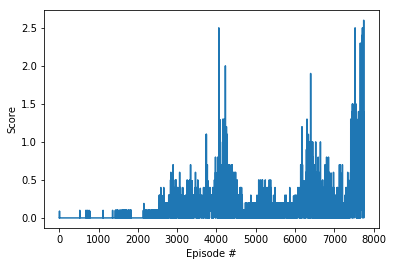

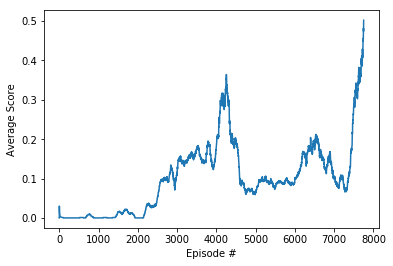

In [19]:
scores_deque = deque(maxlen=100)
scores = []
scores_avg = []
episodes = 100000

PRINT_EVERY = 100

device = 'cpu'

print(state_size)
print('action_size: ', action_size)
maddpgagent = MADDPG(2,state_size, action_size, 0) 

for e in range(episodes):                                   
    env_info = env.reset(train_mode=True)[brain_name]    
    states = env_info.vector_observations                  
    score = np.zeros((n_agents,))
    
    while True:
        actions = maddpgagent.act(states)
        env_info = env.step(actions)[brain_name]           
        
        next_states = env_info.vector_observations
        rewards = env_info.rewards 
        re = np.asarray(rewards)

        
        dones = env_info.local_done  
        
        score += np.array(re)
       
        maddpgagent.step(states, actions, rewards, next_states, dones)
        
        states = next_states
        
        if any(dones):                                 
            break
        
 
    score_max = np.max(score)
    scores.append(score_max)
    scores_deque.append(score_max)
    score_avg = np.mean(scores_deque)
    scores_avg.append(score_avg)
    
    if score_avg >= 0.5:
        maddpgagent.save_weights()
        print("\rSolved! In episode: {} \tAvg score: {:.2f}".format(e+1, score_avg))
        break
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tAvg score: {:.2f}'.format(e+1, score_avg))
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
def plot_smooth(reward, smoothing_window = 10):
    scores = pd.DataFrame({'Average':reward})
    fig = plt.figure(figsize=(10,5))
    plt.grid(True)
    plt.style.use('seaborn-bright')
    rewards_smoothed = scores.rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(['Average Reward'])
    plot_name = 'Tenis.png'
    plt.savefig(plot_name)

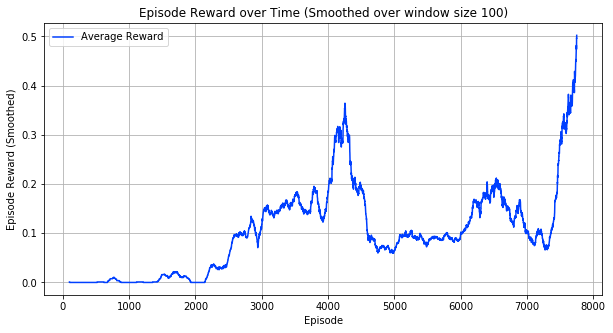

In [22]:
plot_smooth(scores,100)

### Save trained model and scores

In [23]:
def save_scores(scores, file_name):
    with open(file_name, 'w') as f:
        for score in scores:
            f.write("%s\n"%(score))
        f.close()
    print('Test scores saved in', file_name)

In [24]:
save_scores(scores,'scores.csv')

Test scores saved in scores.csv


In [25]:
maddpgagent.save_weights()


In [26]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations

In [27]:
maddpgagent.act(states, False)

C:\Users\nbbor\Anaconda3\envs\tf17\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


array([[-0.99936199,  1.        ],
       [-0.99999917, -0.99999982]])

### Finally: playing with trained agents!

In [30]:
#trained agents' play
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(n_agents)                          # initialize the score (for each agent)
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        actions = maddpgagent.act(states, False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 1.0000000149011612
Score (max over agents) from episode 2: 0.7900000121444464
Score (max over agents) from episode 3: 0.30000000447034836
Score (max over agents) from episode 4: 0.20000000298023224
Score (max over agents) from episode 5: 0.7000000104308128


#### Conclussion:

The implementation of MADDPG follows an intuitive extension to the classic DDPG algorithm, but making the critics aware of other agents' states and actions to mantain the markovian property of the environment.

As possible improvements for this model, I'd like to fine-tune the hyperparameters in order to achieve a better learning curve, in particular to avoid the learning downgrade at around 4000 training steps.